# Data setup

In this notebook, we run all of the functions necessary for setting up the data that is later displayed on the website.


In [7]:
from helper_functions import setup
import numpy as np
import matplotlib.pyplot as plt
import helper_functions as hf
from helper_functions.classes.sport_event import SportEvent
from helper_functions.setup.match_scheduling import determine_rotated_matchups_for_sport, write_match_backup
from helper_functions.classes.match import Match
from helper_functions.classes.player import Player
from itertools import combinations
import pandas as pd
from itertools import combinations
from datetime import datetime, timedelta, time, date
# hf.SPORTS_EVENTS["volleyball"].subteams


In [ ]:
# Initialize some files for streamlit
# hf.generate_sports_page_files()


## Sanitize player data

First, we simply load the responses and anonymize them.

In [6]:
df = setup.sanitize_and_anonymize_data(overwrite=True, verbose=False, anonymize=False)

print(f"{len(df)} entries, of which {np.sum(~df.is_postdoc)} are PhDs and {np.sum(df.is_postdoc)} are postdocs")

endings = [email.split("@")[1] if email != "???" else email for email in df["email"]]
print(len([end for end in endings if end == "???"]), "unknown email-addresses.")
# df.sort_values("num_sports", ascending=False)[["name", "num_sports"]].head(3)



94 entries, of which 72 are PhDs and 22 are postdocs
0 unknown email-addresses.


In [4]:
# from helper_functions.setup.openai_image_download import generate_all_images, save_resized_animal_images
# animals = [animal.lower() for animal in df["nickname"]]
# # The following operation uses up openai credits.
# generate_all_images([])
# save_resized_animal_images(200)
# animals[-3:]


## Team generation

Since we now have all the player data including the sports where they're available, we can generate the teams based on this information.

We want to keep them balanced with regards to all sports; This  is handled in the `create_teams` routine.

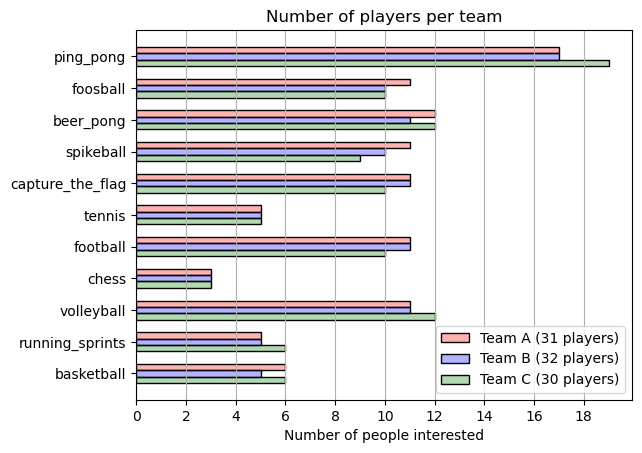

In [5]:
teams = setup.create_teams()
teams[0].player_df.head(3)
fig, ax = plt.subplots()
for team in hf.ALL_TEAMS:
    team.plot_sports_num()
ax.set_title("Number of players per team")
ax.legend();
# import pandas as pd
# players = pd.concat([team.player_df for team in hf.ALL_TEAMS])
# players = teams[1].player_df
# players[players["beer_pong"] & (players["num_sports"] < 4)][["nickname", "num_sports"] + hf.SPORTS_LIST].style.highlight_max()


In [6]:
# from helper_functions.setup.openai_image_download import generate_all_images, save_resized_animal_images
# animals = [animal.lower() for animal in df["nickname"]]
# # The following operation uses up openai credits.
# generate_all_images([])
# save_resized_animal_images(150)
# animals[-3:]


## Subteam generation

Now we're getting to the spicy stuff!

We can generate the subteams for each main team, but there's a few caveats:

- Some of the sports are going to happen simultaneously, which is accounted for by the SportEvent class keeping book about that, and weights that are assigned while subteams are drawn.
- Some players have only chosen one sport. To make sure they can attend that, we are also adjusting their weights while being drawn.
- Some of the sports do not have traditional subteam generation, which we need to account for.

### Generate the subteams for each sport

For running/sprints, everyone is on their own, and we have different events.\
As a first iteration, we just group everyone to be in their own subteam.\
Conveniently, all reserve players are also taking part in the other concurrent events.

Same with chess.

In [7]:
# from helper_functions.setup import generate_all_subteams , try_switch_players
# for team in teams:
#     print(f"MAIN: {team.name}")
#     all_subteams = generate_all_subteams(team, verbose=False)
#     # Resolve all monday conflicts:
#     try_switch_players("Ill-fated Meerkat", "Thankful Kakapo", "running_sprints", all_subteams)
#     try_switch_players("Ideal Vaquita", "Ignorant Lemur", "basketball", all_subteams)
#     try_switch_players("Dramatic Hyena", "Amusing Seal", "volleyball", all_subteams)
#     try_switch_players("Pushy Bulldog", "Minty Possum", "running_sprints", all_subteams)
#     try_switch_players("Excited Rabbit", "Minty Possum", "volleyball", all_subteams)
#     try_switch_players("Reflecting Pug", "Scientific Angelfish", "volleyball", all_subteams)
#     try_switch_players("Alarmed Bird", "Scientific Angelfish", "basketball", all_subteams)
#     # Resolve all tuesday conflicts:
#     try_switch_players("Dramatic Hyena", "Trifling Tarpon", "football", all_subteams)
#     try_switch_players("Awkward Cichlid", "Nice Albatross", "football", all_subteams)
#     try_switch_players("Excited Rabbit", "Sneaky Quokka", "football", all_subteams)
#     # Try to resolve thursday conflicts. Here, we mainly ensure that the players that attend both CdF and Spikeball are in the same Spikeball subteam so we can reschedule it more easily.
#     try_switch_players("Amusing Seal", "Lovely Heron", "spikeball", all_subteams)
#     try_switch_players("Minty Possum", "Sneaky Quokka", "spikeball", all_subteams)
#     # Friday
#     try_switch_players("Magnificent Barracuda", "Dishonest Fangtooth", "beer_pong", all_subteams)
#     try_switch_players("Marvelous Opossum", "Damaged Fly", "foosball", all_subteams)
#     try_switch_players("Ill-fated Meerkat", "Trivial Uguisu", "beer_pong", all_subteams)
#     try_switch_players("Unwritten Saiga", "Minty Possum", "beer_pong", all_subteams)
#     team.add_subteam_keys(all_subteams)
#     team.create_backup()
    
# hf.ALL_TEAMS = teams
# teams[1].player_df[teams[1].player_df["running_sprints"]][["nickname", "subteam_running_sprints"]]


In [8]:
df = hf.turn_series_list_to_dataframe([subteam.as_series for subteam in hf.ALL_SUBTEAMS.values() if subteam.is_reserve])
df["reserve_num"] = df["players"].apply(len)
df = df.sort_values("reserve_num")
all_players = [player for player_list in df["players"] for player in player_list]
names, counts = np.unique(all_players, return_counts=True)
print({player: count for player, count in zip(names, counts) if count > 1})
df[["sport", "team_key", "players", "reserve_num"]]


{'Alarmed Bird': 2, 'Awkward Cichlid': 2, 'Cool Weasel': 2, 'Damaged Fly': 3, 'Excited Rabbit': 3, 'Extra-small Coyote': 2, 'Failing Muskrat': 2, 'Gargantuan Okapi': 2, 'Ideal Vaquita': 2, 'Ill-fated Meerkat': 2, 'Limp Monkey': 2, 'Lovely Heron': 2, 'Magnificent Barracuda': 3, 'Minty Possum': 2, 'Motherly Woodpecker': 2, 'Nutty Sheep': 2, 'Radiant Booby': 2, 'Scientific Angelfish': 2, 'Trivial Uguisu': 3, 'Unwritten Saiga': 2}


,sport,team_key,players,reserve_num
1,running_sprints,A,[Nutty Sheep],1
26,spikeball,C,[Unwritten Saiga],1
19,ping_pong,B,[Awkward Cichlid],1
9,ping_pong,A,[Limp Monkey],1
10,basketball,B,[Trivial Uguisu],1
11,running_sprints,B,[Ill-fated Meerkat],1
0,basketball,A,"[Damaged Fly, Ideal Vaquita]",2
25,capture_the_flag,C,"[Gargantuan Okapi, Rewarding Ermine]",2
24,tennis,C,"[Failing Muskrat, Sneaky Quokka]",2
23,football,C,"[Excited Rabbit, Neglected Harrier]",2


## Match scheduling

Now that all subteams have been determined, we can start scheduling the matches between them.

This process provides several challenges:

- We need to find a way for each subteam to play only against subteams form the other main teams, and this in a balanced manner.
- We need to consider that the same subteam can't play at two pitches at the same time.
- We need to look out for players that are doubly-booked and try to find workarounds.
- **Ping pong** is a big headache:
  - We want each player to have one match against one player of each of the other teams, but not have the other two players face each other to avoid grouping effects.
  - We want to schedule matches every day.
  - We want these matches to not overlap with any of the player's other activities.


In [38]:

def reshuffle_list(list_to_shuffle: list, interval=2) -> list:
    """
    Reshuffles a list by taking elements at regular intervals and concatenating them.

    Parameters
    ----------
    list_to_shuffle (list): The list to be reshuffled.
    interval (int, optional): The interval at which elements are taken from the list. Default is 2.

    Returns
    -------
    list: The reshuffled list.

    Example
    -------
    >>> my_list = [1, 2, 3, 4, 5]
    >>> reshuffle_list(my_list, interval=3)
        --> [1, 4, 2, 5, 3]
    This is equivalent to --> my_list[::3] + my_list[1::3] + my_list[2::3]
    """
    slices = [slice(i, None, interval) for i in range(interval)]
    return [entry for my_slice in slices for entry in list_to_shuffle[my_slice]]

def schedule_matches(sport_event: SportEvent) -> list[Match]:
    matchups = determine_rotated_matchups_for_sport(hf.ALL_SUBTEAMS, sport_event.sanitized_name)
    # Shuffle them around a bit such that the same subteam doesn't have matches at the same time
    matchups = reshuffle_list(matchups, 3)
    courts = [
        str(i + 1)
        for _ in range(len(matchups) // sport_event.num_pitches + 1)
        for i in range(sport_event.num_pitches)
    ]
    date_range = pd.date_range(
            start=sport_event.start,
            periods=len(matchups),
            freq=sport_event.match_duration,
        )
    dates = [
        date
        for date in date_range
        for _ in range(sport_event.num_pitches)
    ]
    matches = [Match(sport_event.sanitized_name, start, sport_event.match_duration, matchup[0], matchup[1], location) for start, matchup, location in zip(dates, matchups, courts)]
    return matches


In [49]:

ALL_MATCHES = {match.match_key: match for sport in hf.SPORTS_EVENTS.values() for match in schedule_matches(sport) if sport.sanitized_name not in ["ping_pong", "running_sprints"]}

sprints = hf.SPORTS_EVENTS["running_sprints"]
subteams = [team for team in sprints.subteams if not team.is_reserve]
for comb in combinations(subteams, 2):
    match_ = Match("running_sprints", sprints.start, timedelta(minutes=75), comb[0], comb[1], "Main pitch")
    ALL_MATCHES[match_.match_key] = match_

# Resolve all conflicts for spikeball/CdF:
ALL_MATCHES["spikeball_B: 2_C: 4"].switch_with_other(ALL_MATCHES["spikeball_A: 3_B: 2"])
ALL_MATCHES["spikeball_B: 4_C: 3"].switch_with_other(ALL_MATCHES["spikeball_A: 2_B: 1"])

ALL_MATCHES["spikeball_B: 1_C: 2"].set_time_and_loc(18, 45, "1")
# # Move these two matches to the back as they're otherwise not properly switchable:
ALL_MATCHES["spikeball_A: 1_B: 4"].set_time_and_loc(19, 45, "1")
ALL_MATCHES["spikeball_C: 4_A: 4"].set_time_and_loc(19, 45, "2")
ALL_MATCHES["spikeball_A: 2_B: 1"].set_time_and_loc(19, 45, "3")

# Resolve one remaining conflict for beer pong/foosball:
ALL_MATCHES["foosball_A: 1_B: 3"].switch_with_other(ALL_MATCHES["foosball_A: 4_B: 4"])

num_conflicts = np.sum([comb[0].has_hard_collision(comb[1], verbose=True) for comb in combinations(ALL_MATCHES.values(), 2)])
if num_conflicts == 0:
    print("Successfully removed all conflicts. Yay!")

match_df = hf.turn_series_list_to_dataframe([m.as_series for m in ALL_MATCHES.values()]).sort_values(["time", "location"])
match_df[match_df["sport"] == "tennis"]

# team_a	team_b	time
# 29	A: 1	B: 1	17:45
# 30	B: 1	C: 1	18:15
# 31	C: 1	A: 1	18:45
# ALL_MATCHES["spikeball_B: 2_C: 4"]


Successfully removed all conflicts. Yay!


,sport,team_a,team_b,location,day,time,result,winner,start,duration,full_key,team_a_key,team_b_key
21,tennis,A: Motherly Woodpecker,B: Striped Himalayan,1,Tuesday,17:45,,,2024-04-30 17:45:00,2700,tennis_A: 2_B: 1,A: 2,B: 1
22,tennis,A: Pricey Collie,B: Faint Gorilla,2,Tuesday,17:45,,,2024-04-30 17:45:00,2700,tennis_A: 1_B: 3,A: 1,B: 3
23,tennis,A: Fickle Gecko,B: Animated Yak,3,Tuesday,17:45,,,2024-04-30 17:45:00,2700,tennis_A: 3_B: 2,A: 3,B: 2
24,tennis,B: Striped Himalayan,C: Well-documented Dodo,1,Tuesday,18:30,,,2024-04-30 18:30:00,2700,tennis_B: 1_C: 3,B: 1,C: 3
25,tennis,B: Faint Gorilla,C: Unwritten Saiga,2,Tuesday,18:30,,,2024-04-30 18:30:00,2700,tennis_B: 3_C: 1,B: 3,C: 1
26,tennis,B: Animated Yak,C: Neglected Harrier,3,Tuesday,18:30,,,2024-04-30 18:30:00,2700,tennis_B: 2_C: 2,B: 2,C: 2
27,tennis,C: Well-documented Dodo,A: Motherly Woodpecker,1,Tuesday,19:15,,,2024-04-30 19:15:00,2700,tennis_C: 3_A: 2,C: 3,A: 2
28,tennis,C: Unwritten Saiga,A: Pricey Collie,2,Tuesday,19:15,,,2024-04-30 19:15:00,2700,tennis_C: 1_A: 1,C: 1,A: 1
29,tennis,C: Neglected Harrier,A: Fickle Gecko,3,Tuesday,19:15,,,2024-04-30 19:15:00,2700,tennis_C: 2_A: 3,C: 2,A: 3


In [50]:
from datetime import datetime, timedelta, time, date
def get_all_timeslots(avail_days: list[str]) -> list[datetime]:
    """Retrieve all possible timeslots for the given available weekdays.
    """
    all_timeslots = []
    for day_tup in [(4, 29), (4, 30), (5, 2), (5, 3)]:
        day = date(2024, day_tup[0], day_tup[1])
        if day.strftime("%A").lower() not in avail_days:
            continue
        all_timeslots += [datetime.combine(day, time(17, 45))]
        all_timeslots += [datetime.combine(day, time(hour, minute)) for hour in range(18, 21) for minute in [15, 45]]
    return all_timeslots



In [51]:


weekdays = {day: [] for day in ["monday", "tuesday", "thursday", "friday"]}
for sport in hf.SPORTS_EVENTS.values():
    if sport.sanitized_name == "ping_pong":
        continue
    for day in sport.days:
        weekdays[day].append(sport.sanitized_name)

def get_weekdays_for_sports(sports: list[str]) -> list[str]:
    return [day for day, day_sports in weekdays.items() if len(set(day_sports).intersection(sports)) >= 1]

all_players = hf.get_players(True).set_index("nickname").fillna("")
matchups = determine_rotated_matchups_for_sport(hf.ALL_SUBTEAMS, "ping_pong")
matchup = matchups[1]

all_free_times = []
for matchup in matchups:
    match_players = all_players.loc[matchup[0].players + matchup[1].players]
    avail_days = [day for day in weekdays if all(match_players[f"avail_{day}"])]
    player_sports = [sport for sport in hf.SPORTS_LIST if any(match_players[f"subteam_{sport}"].str.isdigit())]
    busy_days = get_weekdays_for_sports(player_sports)
    preferred_days = [day for day in avail_days if day not in busy_days]
    days_to_check = preferred_days if len(preferred_days) > 0 else avail_days

    slots = get_all_timeslots(avail_days)
    other_player_matches = [match for match in ALL_MATCHES.values() if any([match.contains_player(player) for player in match_players.index])]
    time_frames = [match_.get_buffered_timetuple(15) for match_ in other_player_matches]
    free_times = [time_ for time_ in slots  if not any(slot[0] <= time_ < slot[1] for slot in time_frames)]
    all_free_times.append(free_times)


In [62]:
banned_timeslots = []
pp_matches = {}
num_unsuccessful = 0

def get_matches_at_timeslot(start_time: datetime, current_matches: list[Match]) -> list[Match]:
    return [match for match in current_matches if match.start == start_time]

# sorted(zip(matchups, all_free_times), key=lambda pair: len(pair[1]))
for matchup, timeslots in sorted(zip(matchups, all_free_times), key=lambda pair: len(pair[1])):
    avail_timelots = [slot for slot in timeslots if banned_timeslots.count(slot) < 3]
    # The following ensures that players will not intersect with themselves:
    avail_timelots = [slot for slot in avail_timelots if all([len(set(s.players).intersection(match.involved_players)) == 0 for match in get_matches_at_timeslot(slot, list(pp_matches.values())) for s in matchup])]
    if len(avail_timelots) == 0:
        num_unsuccessful += 1
        print(matchup)
        continue
    match_time = avail_timelots[0]
    banned_timeslots.append(match_time)
    location = str(banned_timeslots.count(match_time))
    match_ = Match("ping_pong", match_time, timedelta(minutes=30), matchup[0], matchup[1], location)
    pp_matches[match_.match_key] = match_
print(num_unsuccessful)
pp_matches = dict(sorted(pp_matches.items(), key=lambda match_: match_[1].start))
full_match_dict = ALL_MATCHES | pp_matches

# We need to move these two to a little earlier time as they 
full_match_dict["ping_pong_B: 10_C: 12"].set_time_and_loc(17, 30, "2")
full_match_dict["ping_pong_C: 11_A: 03"].set_time_and_loc(17, 30, "3")

write_match_backup(list(full_match_dict.values()), overwrite=True)

num_conflicts = np.sum([comb[0].has_hard_collision(comb[1], verbose=True) for comb in combinations(full_match_dict.values(), 2)])
if num_conflicts == 0:
    print("Successfully removed all conflicts. Yay!")
pd.DataFrame([m.as_series for m in pp_matches.values()])#.sort_values(["day", "time", "location"])
match_df[match_df["sport"] == "volleyball"]


0
Successfully removed all conflicts. Yay!


,sport,team_a,team_b,location,day,time,result,winner,start,duration,full_key,team_a_key,team_b_key
3,volleyball,A: 2,B: 1,1,Monday,17:45,,,2024-04-29 17:45:00,2700,volleyball_A: 2_B: 1,A: 2,B: 1
4,volleyball,A: 1,B: 2,2,Monday,17:45,,,2024-04-29 17:45:00,2700,volleyball_A: 1_B: 2,A: 1,B: 2
5,volleyball,B: 1,C: 2,1,Monday,18:30,,,2024-04-29 18:30:00,2700,volleyball_B: 1_C: 2,B: 1,C: 2
6,volleyball,B: 2,C: 1,2,Monday,18:30,,,2024-04-29 18:30:00,2700,volleyball_B: 2_C: 1,B: 2,C: 1
7,volleyball,C: 2,A: 1,1,Monday,19:15,,,2024-04-29 19:15:00,2700,volleyball_C: 2_A: 1,C: 2,A: 1
8,volleyball,C: 1,A: 2,2,Monday,19:15,,,2024-04-29 19:15:00,2700,volleyball_C: 1_A: 2,C: 1,A: 2


In [ ]:

matches = [Match.from_dataframe_entry(m, hf.ALL_SUBTEAMS) for _, m in match_df.iterrows()]
match_df2 = hf.turn_series_list_to_dataframe([m.as_series for m in matches])
# all(match_df2 == match_df)
# match_df.drop(columns=["location"])
